In [94]:
torch.cuda.empty_cache()

In [9]:
import glob
class GANImageDataset(Dataset):
    def __init__(self, weather, town, model, transform=None, target_transform=None):
        self.dir = './Datasets/'+weather+'/'+town+'/'+model+'/test_latest/images'
        self.transform = transform
        self.target_transform = target_transform
        self.real = glob.glob(self.dir+'/*real.png')


    def __len__(self):
        return len(list(self.real))

    def __getitem__(self, idx): 
        img_path = self.real[idx]
        image = read_image(img_path)
        label_name_split = self.real[idx].split('_')
        label_name = label_name_split[0]+'_'+label_name_split[1]+'_fake.png'
        label = read_image( label_name)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import carla
from utils import AE_initalize_weights
from utils import generate_semantic_im
from utils import replace


from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import DataLoader, Subset 
from torch.utils.data import ConcatDataset
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class PerceptionNet(nn.Module):

    def __init__(self):
        super(PerceptionNet,self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.conv6a = nn.Conv2d(512, 64, kernel_size=4, stride=1)
        self.conv6b = nn.Conv2d(512, 64, kernel_size=4, stride=1)
        
        self.conv7 = torch.nn.ConvTranspose2d(64,512, kernel_size =4, stride=1)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.conv8 = torch.nn.ConvTranspose2d(512,256, kernel_size =4, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.conv9 = torch.nn.ConvTranspose2d(256,128, kernel_size =4, stride=2, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.conv10 = torch.nn.ConvTranspose2d(128,64, kernel_size =4, stride=2, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        
        self.conv11 = torch.nn.ConvTranspose2d(64,32, kernel_size =4, stride=2, padding=1)
        self.bn10 = nn.BatchNorm2d(32)
        
        self.conv12 = torch.nn.ConvTranspose2d(32,13, kernel_size =4, stride=2,padding=1)
        
            
    def encode(self, x):
        x = F.leaky_relu(self.conv1(x),negative_slope=0.02)
        x = F.leaky_relu(self.bn2(self.conv2(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn3(self.conv3(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn4(self.conv4(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn5(self.conv5(x)),negative_slope=0.02)
        return self.conv6a(x)

    
    def decode(self, x):
        x = F.leaky_relu(self.bn6(self.conv7(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn7(self.conv8(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn8(self.conv9(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn9(self.conv10(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn10(self.conv11(x)),negative_slope=0.02)
        return torch.sigmoid(self.conv12(x))

    
    def forward(self, x):
        x = x.to(device, dtype=torch.float32)
        latent = self.encode(x)
        out = self.decode(latent)
        return out, latent

In [5]:
master = PerceptionNet()
servant = PerceptionNet()

master.to(device)
master.load_state_dict(torch.load('./AE_params/model_46.final'))
master.eval()

servant.to(device)
servant.apply(AE_initalize_weights)
servant.train()


PerceptionNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6a): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv6b): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv7): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, mom

In [15]:
train_data = GANImageDataset('dry-wet','Town04','wetcyclegan4')
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = GANImageDataset('dry-wet','Town04','wetcyclegan4')
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [16]:
train_data.__len__()

21026

In [31]:
optimizer = torch.optim.Adam(servant.parameters(), lr=0.0003)
loss_fn = nn.MSELoss()

In [34]:
def train(epoch):
    global step
    servant.train()
    writer = SummaryWriter()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        org_domain = data[0]
        new_domain = data[1]
        batch_size = new_domain.shape[0]
        with torch.no_grad():
            _,latent_true = master(org_domain)
        
        optimizer.zero_grad()
        _,latent_hat = servant(new_domain)
        loss = loss_fn(latent_hat,latent_true)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_size * batch_idx, len(train_loader.dataset),
            100. * batch_idx / len(train_loader),
            loss.item() / len(data)))

        writer.add_scalar("AE Loss", loss.item() / len(data[0]),step)
        step += 1

    avg_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.8f}'.format(
          epoch, avg_loss))
    writer.flush()
    return avg_loss
    
    


def test(epoch):
    servant.eval()
    writer = SummaryWriter()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            org_domain = data[0]
            new_domain = data[1]
            _,latent_true = master(org_domain)
            _,latent_hat = servant(new_domain)
            test_loss += loss_fn(latent_hat,latent_true).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.8f}'.format(test_loss))
    writer.add_scalar("AE test Loss", test_loss,epoch)
    writer.flush()
    writer.close()


for epoch in range(1, 10 + 1):
    step = 0
    smallest_loss = 1000
    avg_loss = train(epoch)
    if avg_loss < smallest_loss:
        torch.save(servant.state_dict(), './AE_params/dry-wet_2.best')
    #test(epoch)
    torch.save(servant.state_dict(), './AE_params/dry-wet_2.final')

Train Epoch: 1 [0/21026 (0%)]	Loss: 0.290350
Train Epoch: 1 [64/21026 (0%)]	Loss: 0.319945
Train Epoch: 1 [128/21026 (1%)]	Loss: 0.303181
Train Epoch: 1 [192/21026 (1%)]	Loss: 0.280903
Train Epoch: 1 [256/21026 (1%)]	Loss: 0.274981
Train Epoch: 1 [320/21026 (2%)]	Loss: 0.312454
Train Epoch: 1 [384/21026 (2%)]	Loss: 0.335438
Train Epoch: 1 [448/21026 (2%)]	Loss: 0.325439
Train Epoch: 1 [512/21026 (2%)]	Loss: 0.318673
Train Epoch: 1 [576/21026 (3%)]	Loss: 0.274362
Train Epoch: 1 [640/21026 (3%)]	Loss: 0.288796
Train Epoch: 1 [704/21026 (3%)]	Loss: 0.274422
Train Epoch: 1 [768/21026 (4%)]	Loss: 0.302207
Train Epoch: 1 [832/21026 (4%)]	Loss: 0.300175
Train Epoch: 1 [896/21026 (4%)]	Loss: 0.252194
Train Epoch: 1 [960/21026 (5%)]	Loss: 0.318100
Train Epoch: 1 [1024/21026 (5%)]	Loss: 0.314378
Train Epoch: 1 [1088/21026 (5%)]	Loss: 0.281259
Train Epoch: 1 [1152/21026 (5%)]	Loss: 0.298572
Train Epoch: 1 [1216/21026 (6%)]	Loss: 0.294165
Train Epoch: 1 [1280/21026 (6%)]	Loss: 0.264663
Train Epoch

(1, 128, 128)


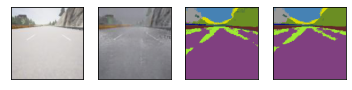

In [137]:
num = random.randint(1,20000)
data = train_data.__getitem__(num)
imgs = []
org = data[0]
new = data[1]

_,latent = master(data[0].reshape(1,3,128,128))
_,new_lat = servant(data[1].reshape(1,3,128,128))
imgs.append(Image.fromarray(org.numpy().transpose(1,2,0)))
imgs.append(Image.fromarray(new.numpy().transpose(1,2,0)))

sem = master.decode(new_lat).detach().cpu().argmax(dim=1)

imgs.append(generate_semantic_im(org,master))
imgs.append(replace(sem.numpy().reshape(1,128,128).transpose(1,2,0)))
fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
for i, img in enumerate(imgs):
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [60]:
sem.numpy().reshape(13,128,128)

array([[[2.44303402e-02, 2.06218101e-03, 2.28911429e-03, ...,
         2.27603111e-02, 1.40220314e-01, 1.25275359e-01],
        [3.41317966e-04, 2.14852334e-05, 2.73792966e-06, ...,
         4.40190546e-03, 2.41087424e-03, 4.87988479e-02],
        [3.49047710e-04, 1.61600758e-06, 4.78934953e-06, ...,
         1.45536847e-03, 7.36606133e-04, 1.80284325e-02],
        ...,
        [5.27722314e-02, 4.04320098e-03, 3.88075295e-03, ...,
         3.80736333e-03, 7.25114252e-03, 7.86732212e-02],
        [1.91590860e-02, 1.37074906e-02, 5.26635488e-03, ...,
         8.27475917e-03, 5.11673139e-03, 2.74521858e-02],
        [2.56188989e-01, 3.66126336e-02, 4.03792597e-02, ...,
         4.48789522e-02, 4.59873043e-02, 1.63385183e-01]],

       [[9.17957544e-01, 9.77948189e-01, 9.93574440e-01, ...,
         1.77677050e-01, 2.00150967e-01, 4.36161101e-01],
        [9.70984817e-01, 9.99780357e-01, 9.99453604e-01, ...,
         2.49222424e-02, 7.11276457e-02, 8.01168382e-02],
        [9.58364189e-01, 